#### Hartree-Fock in Pytorch

In [1]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/usdb.nat'


SPS=SingleParticleState(file_name=file_name)

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:57<00:00,  2.39s/it]


In [58]:
nparticles_a=4
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{8}$Be'

In [59]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-59.93848563]
total_m= [-3.07168028e-17]
dimension= 4206


Hartree-Fock method

In [60]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)


In [61]:

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -27.139860
Step   20 | Energy = -32.168288
Step   40 | Energy = -36.720149
Step   60 | Energy = -40.672032
Step   80 | Energy = -44.095626
Step  100 | Energy = -46.808856
Step  120 | Energy = -48.615421
Step  140 | Energy = -49.539822
Step  160 | Energy = -50.089838
Step  180 | Energy = -50.514989
Step  200 | Energy = -50.880496
Step  220 | Energy = -51.216529
Step  240 | Energy = -51.544034
Step  260 | Energy = -51.881786
Step  280 | Energy = -52.245742
Step  300 | Energy = -52.649027
Step  320 | Energy = -53.099236
Step  340 | Energy = -53.588839
Step  360 | Energy = -54.085978
Step  380 | Energy = -54.541459
Step  400 | Energy = -54.912139
Step  420 | Energy = -55.179635
Step  440 | Energy = -55.351214
Step  460 | Energy = -55.449488
Step  480 | Energy = -55.500606
Step  500 | Energy = -55.525650
Step  520 | Energy = -55.537688
Step  540 | Energy = -55.543490
Step  560 | Energy = -55.546293
Step  580 | Energy = -55.547642
Step  599 | Energy = -55.548261


In [62]:
print(torch.sum(torch.abs(model.C_n)))

tensor(10.5726, dtype=torch.float64, grad_fn=<SumBackward0>)


In [63]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p


    return psi  # [F]

def slater_determinants_only_neutrons(C_n, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]


    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()


        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]




        det_n = torch.det(Cn_sub)

        psi[i] = det_n 

    return psi  # [F]


In [64]:

#psi_hf=slater_determinants_only_neutrons(model.C_n, torch.tensor(NSMHamiltonian.basis))
psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)



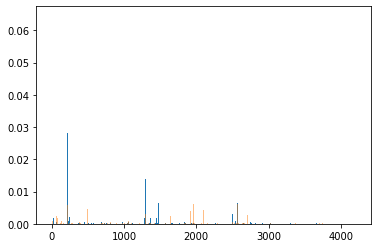

-56.97095529071218
fidelity= 0.42878321775052625


In [65]:
plt.bar(np.arange(psi_hf.shape[0]),psi_hf.conjugate()*psi_hf)
plt.bar(np.arange(psi_hf.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0],alpha=0.5)
plt.show()

print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)


print('fidelity=',psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)))

In [32]:
def check_orthonormal(C, tol=1e-6):
    I = torch.eye(C.shape[1], dtype=C.dtype, device=C.device)
    test = C.T @ C
    return torch.allclose(test, I, atol=tol)

print(check_orthonormal(model.C_p))

AttributeError: 'HFEnergyFunctionalNuclear' object has no attribute 'C_p'

#### Sample Based Diagonalization HF and exact Gs

In [66]:
n_instances=9000

In [36]:
prob_exact=np.conjugate(psi0[:,0])*psi0[:,0]
nbatch=50
ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],1)
errors_sdg_gs=[]
energies_sdg_gs=[]
fidelities_exact=[]

deviations_exact=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_exact)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_exact.append(ensamble_fidelity)
        errors_sdg_gs.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_gs.append(ensamble_energy)
        deviations_exact.append(std_energy)
        print(ensamble_energy)


-20.03471478667097
-20.987249071318043
-21.328183703874565
-21.605195686393355
-21.869052924633458
-22.01094754158457
-22.300337561145128
-22.396489610220602
-22.606652112036624
-22.683102047313326
-22.827742121171536
-22.967613567611753
-23.007520883079174
-23.054725404587625
-23.10231257402846
-23.202285062664703
-23.2560804886138
-23.34656311220801
-23.43540849729037
-23.426849185697534
-23.479231936421233
-23.52566369463745
-23.57341822280479
-23.572953232130185
-23.63227798289189
-23.64486122808574
-23.69913924750123
-23.714317527340835
-23.732324325600025
-23.75810627790955
-23.75581204038466
-23.784315785556476
-23.798992827888828
-23.809735864749715
-23.82210320506183
-23.829482781340403
-23.835688982457604
-23.848313569490593
-23.860272083846493
-23.873675538243695
-23.872805899132082
-23.885170028339715
-23.889254745190293
-23.894373780666843
-23.90049230264019
-23.904662593905222
-23.908015643484564
-23.91011635386732
-23.913071941520023
-23.916415335791772
-23.9167804158683

In [37]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]
errors_sdg_hf=[]
energies_sdg_hf=[]
fidelities=[]

deviations=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities.append(ensamble_fidelity)
        errors_sdg_hf.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf.append(ensamble_energy)
        deviations.append(std_energy)
        print(ensamble_energy)


-20.435487946196357
-20.767786579261415
-20.901848288891003
-20.99377271410767
-21.0650940752879
-21.254511876582633
-21.209952055074044
-21.3059700886885
-21.401408722821188
-21.42185909725199
-21.571390598780454
-21.599988224840263
-21.69478583963019
-21.771760552145473
-21.79981242218291
-21.92163542402958
-21.955338719689752
-22.043756972288552
-22.073646328302633
-22.18989050968405
-22.22600512696183
-22.275660403829207
-22.34721195943844
-22.370581119987374
-22.462391434342376
-22.459560117725832
-22.51144984961257
-22.539269313389045
-22.61347662706287
-22.683213564058498
-22.707212543193695
-22.684542947048104
-22.79205857711411
-22.78840236311333
-22.82333318462338
-22.882536415104724
-22.92563835039021
-22.977468384915877
-22.993766423905434
-23.001365624240208
-23.000144850168564
-23.092010744410583
-23.13989234418002
-23.14478824116197
-23.187300237611765
-23.18488206583954
-23.21583296752031
-23.224092271431118
-23.244031342723083
-23.257842863984912
-23.274847326942144
-2

Useless

In [ ]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_clever=[]
energies_sdg_hf_clever=[]
fidelities_clever=[]
max_iterations=100
prob_sampler=prob_hf.copy()
ns_instances_clever=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],5)
selection=np.random.choice(np.arange(prob_hf.shape[0]),size=2,replace=False,p=prob_hf)
selected_samples=[selection[0],selection[1]]
effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

prob_sampler[selected_samples]=0
prob_sampler=prob_sampler/np.sum(prob_sampler)

effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
e_old=effective_egs.copy()

for r in range(NSMHamiltonian.hamiltonian.shape[0]-3): 
    
    low_energy=effective_egs.copy()
    for i in range(max_iterations):
        
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=5,replace=False,p=prob_sampler)
        tentative_selection=selected_samples+list(selection)
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[tentative_selection,:][:,tentative_selection]
        egs_tentative,psi0_tentative=eigsh(effective_hamiltonian,k=1,which='SA')

        if effective_egs <= low_energy:
            psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
            final_selection=tentative_selection
            low_energy=effective_egs
            effective_egs=egs_tentative.copy()
            psi_selected[tentative_selection]=psi0_tentative[:,0]
    print(effective_egs)
    selected_samples=final_selection
    prob_sampler[selected_samples]=0
    prob_sampler=prob_sampler/np.sum(prob_sampler)
    fidelities_clever.append(1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0])))
    errors_sdg_hf_clever.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
    energies_sdg_hf_clever.append(effective_egs[0])

    
    

128 127


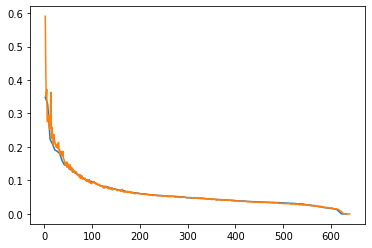

In [28]:
print(len(ns_instances_clever),len(errors_sdg_hf_clever))

plt.plot(ns_instances_clever[:-1],errors_sdg_hf_clever)
plt.plot(ns_instances,errors_sdg_hf)
plt.show()

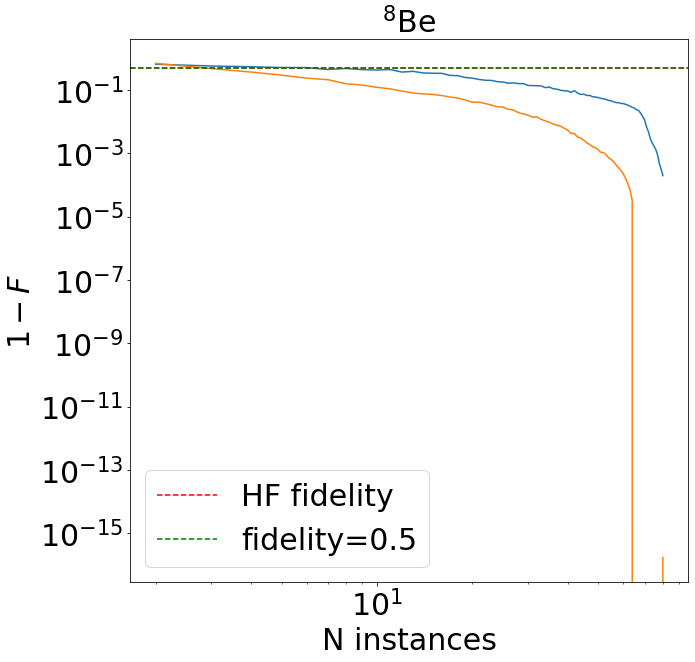

In [38]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')
plt.axhline(y=0.5,label='fidelity=0.5',color='green',linestyle='--')
plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.loglog()
plt.show()

In [39]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_mixed=[]
energies_sdg_hf_mixed=[]
fidelities_mixed=[]
deviations_mixed=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2
        
                
        prob_hf=0.9*prob_hf+0.1*ensamble_prob_selected
        prob_hf=prob_hf/np.sum(prob_hf)
        fidelities_mixed.append(ensamble_fidelity)
        errors_sdg_hf_mixed.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf_mixed.append(ensamble_energy)
        deviations_mixed.append(std_energy)
        print(effective_egs)

[-20.1417858]
[-20.89113058]
[-20.94513252]
[-20.97451914]
[-21.49731611]
[-21.72258226]
[-21.43981805]
[-21.98767433]
[-22.02010209]
[-21.8019076]
[-22.40367973]
[-22.09490742]
[-22.31498318]
[-22.41135915]
[-22.31655092]
[-22.54826874]
[-22.42178192]
[-22.46618983]
[-22.68605964]
[-22.85139563]
[-22.96453175]
[-22.95050325]
[-23.01973567]
[-23.12407304]
[-23.12948881]
[-23.12900691]
[-23.15106927]
[-23.13310798]
[-23.16397984]
[-23.24170371]
[-23.26141899]
[-23.26707968]
[-23.27658564]
[-23.29144946]
[-23.30341812]
[-23.3702043]
[-23.37836192]
[-23.38275828]
[-23.38162275]
[-23.39920407]
[-23.40158468]
[-23.40564901]
[-23.40813199]
[-23.40741188]
[-23.40785111]
[-23.41890737]
[-23.41850523]
[-23.4191063]
[-23.42012855]
[-23.42383076]
[-23.42674296]
[-23.42743084]
[-23.42676219]
[-23.42823739]
[-23.42825832]
[-23.42952561]
[-23.42956004]
[-23.44391839]
[-23.44395157]
[-23.62691502]
[-23.62695276]
[-23.85029412]
[-23.85057266]
[-23.85088836]
[-23.85088911]
[-23.85089]
[-23.85091457]
[-

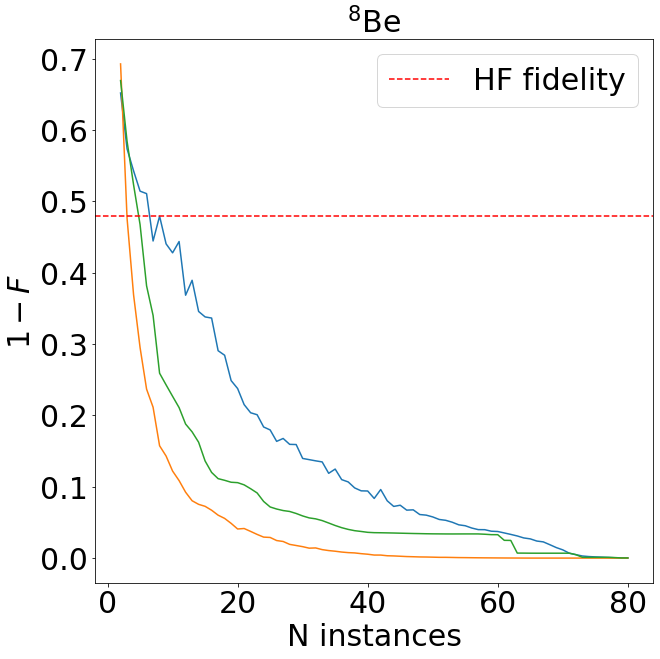

In [40]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)
plt.plot(ns_instances,fidelities_mixed)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')

plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

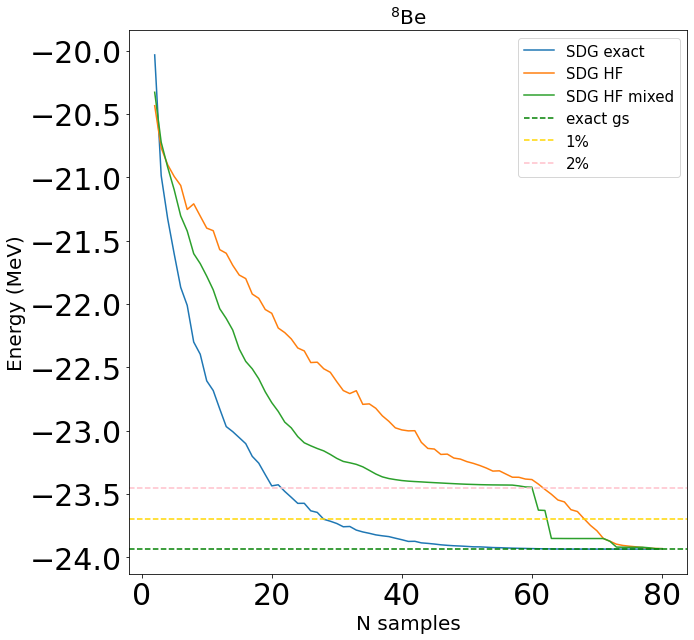

(79,)


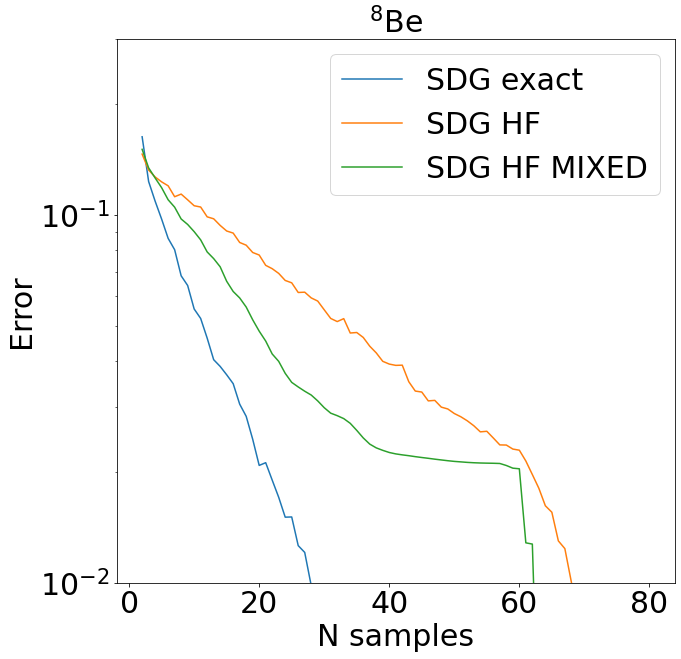

In [41]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')

plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogy()
plt.legend(fontsize=30)
plt.show()

#### Method using a Partial Adapt VQE

In [42]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational,gram_schmidt
from src.hamiltonian_utils import FermiHubbardHamiltonian
import numpy as np
from src.nuclear_physics_utils import SingleParticleState,get_twobody_nuclearshell_model
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
from scipy import sparse
#from adapt_vqe_old import AdaptVQEFermiHubbard

In [43]:
def miquel_constrainer(idxs:List[int]):
    
    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition

def miquel_contrained_3(idx:List[int]):
    size=12    
    i1,i2,j1,j2=idx
    if (i1<size and i2>=size) or (i2<size and i1>=size):
        condition=True
    else:
        condition=False
        
    return condition
    


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

       
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

In [69]:
operator_pool:Dict={}
operator_pool=NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer,miquel_constrainer_2],nbody='two')

print(len(operator_pool))



1928


In [74]:
# old initialization works better than Hartree Fock
min = 10000
for i, b in enumerate(NSMHamiltonian.basis):
    psi = np.zeros(NSMHamiltonian.basis.shape[0])
    psi[i] = 1.0
    value = np.conj(psi) @ NSMHamiltonian.hamiltonian @ psi
    if value < min:
        min = value
        b_min=b
        print(value)
        print(b)
        psi_base = psi
        
psi_initial=psi_base

-39.37004444444443
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
-41.129426984126994
[1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
-44.21689523809523
[1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
-44.21689523809525
[1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
-44.727441269841265
[1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
-48.05152222222222
[1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]


In [ ]:
# %%
random=False




model=AdaptVQEFermiHubbard()

model.set_hamiltonian(NSMHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf,energy_gs=egs[0])
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='BFGS',tolerance_opt=10**-5,tolerance_adapt=10**-5)

fit.configuration_checkpoint=model.callback
fit.init_model(model)
history_energy,history_grad=fit.run()


(Optional) CCVQE with a particular operator pool

In [70]:
vs=[]
ops=[]
keys=[]
for key,op in operator_pool.items():
    
    if key in twobody_matrix.keys():
        vs.append(twobody_matrix[key])
        ops.append(op)
        keys.append(key)
vs=np.abs(np.asarray(vs))

[2.54294732 2.54294732 2.4332     2.4332     2.0568     2.0568
 2.02288071 2.02288071 1.975575   1.975575   1.97039214 1.97039214
 1.94626929 1.94626929 1.93144568 1.93144568 1.90405    1.90405
 1.8823855  1.8823855  1.8823855  1.8823855  1.87742982 1.87742982
 1.79847461 1.79847461 1.73135419 1.73135419 1.70551964 1.70551964
 1.5871     1.5871     1.58036667 1.58036667 1.54848393 1.54848393
 1.54753071 1.54753071 1.5272     1.5272     1.51795    1.51795
 1.4725521  1.4725521  1.4725521  1.4725521  1.45808954 1.45808954
 1.45808954 1.45808954 1.4343     1.4343     1.39956139 1.39956139
 1.372875   1.372875   1.36313125 1.36313125 1.36002231 1.36002231
 1.36002231 1.36002231 1.35154643 1.35154643 1.3349     1.3349
 1.3349     1.3349     1.31918889 1.31918889 1.29435896 1.29435896
 1.29435896 1.29435896 1.24597363 1.24597363 1.23540159 1.22617771
 1.22617771 1.22617771 1.22617771 1.21381875 1.21381875 1.21297042
 1.21297042 1.21297042 1.21297042 1.18268095 1.18268095 1.17956828
 1.179568

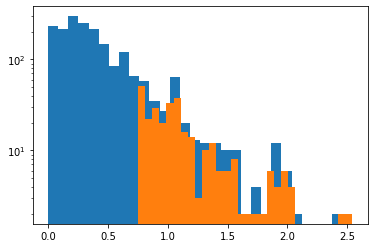

In [71]:
size=300

#selection=np.random.choice(np.arange(vs.shape[0]),size=size,replace=False,p=vs/np.sum(vs))

selection=np.argsort(vs)[-size:][::-1]



selected_vs=vs[selection]

print(np.sort(vs)[-size:][::-1],selected_vs)

plt.hist(vs,bins=30)
plt.hist(selected_vs,bins=30)
#plt.xlim([2,2.5])
plt.semilogy()
plt.show()


new_operator_pool={}
for idx in selection:
    new_operator_pool[(keys[idx])]=ops[idx]

In [ ]:
from src.qml_models import CCVQEFermiHubbard
from scipy.optimize import minimize
model=CCVQEFermiHubbard()
random=None
model.set_hamiltonian(NSMHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf,energy_gs=egs[0])
model.set_operators_pool(operator_pool=new_operator_pool,random=random)

#model.weights=selected_vs.copy()

print(model.weights)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [76]:
res = minimize(
                    model.forward,
                    model.weights,
                    method='BFGS',
                    jac=model.backward,
                    tol=10**-8,
                    callback=model.callback,
                    options={'disp': True},
                )
model.weights = res.x
energy = model.forward(model.weights)
grad_energy = model.backward(model.weights)


print(energy)
print(model.weights)

energy value= -48.37019856992286 

energy value= -48.90039579649411 

energy value= -49.80704330699337 

energy value= -50.97550970092702 

energy value= -52.0267727395858 

energy value= -52.68326556323332 

energy value= -53.24976040823806 

energy value= -53.510354372806475 

energy value= -53.61881835824797 

energy value= -53.77711796762707 

energy value= -53.86025091078392 

energy value= -53.885041821772106 

energy value= -53.927682936297956 

energy value= -53.98478511291379 

energy value= -54.03971034686024 

energy value= -54.092497594881046 



KeyboardInterrupt: 

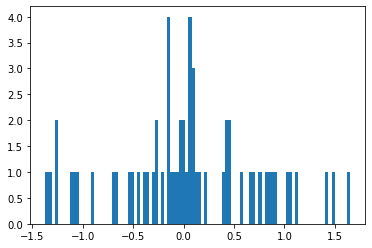

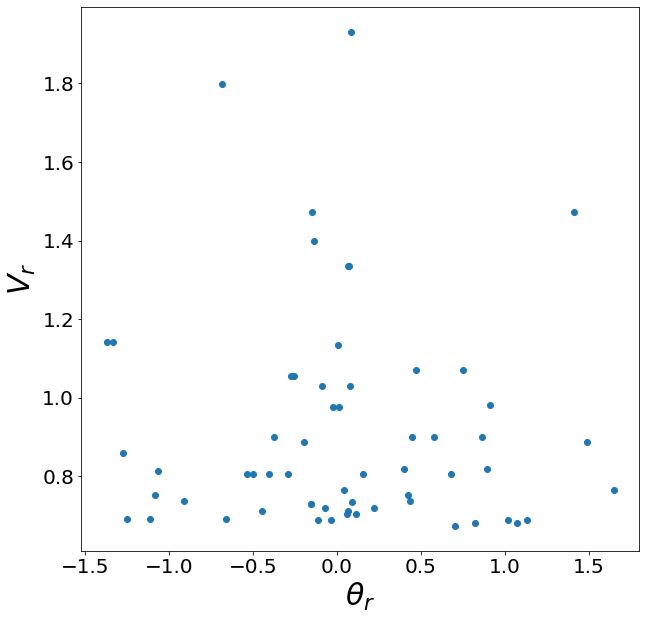

In [57]:
plt.hist(model.weights,bins=100)
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(model.weights,selected_vs)
plt.xlabel(r'$\theta_r$',fontsize=30)
plt.ylabel(r'$V_r$',fontsize=30)
plt.tick_params(labelsize=20)

plt.show()


In [93]:
psi_vqe=model.compute_psi(model.weights)

In [94]:
psi_vqe=model.compute_psi(model.weights)
print(psi_vqe.conjugate().dot(psi_hf)*np.conjugate(psi_vqe.conjugate().dot(psi_hf)))
print(model.weights)

0.6327682272785888
[-2.87156915e-01  6.42129370e-02  2.61319926e-01  6.95500275e-01
  5.34438043e-01 -8.25006243e-01 -2.43430742e-01 -5.22875658e-01
 -1.78759642e-01 -2.96617278e-02 -1.15587014e+00  7.38630185e-02
 -5.51790867e-01  5.10174064e-01  2.15934046e-02 -2.89528497e-01
  5.57131681e-01  4.66210277e-01  7.57431774e-01  2.83250558e-01
  9.31795022e-02 -2.28175836e-01 -1.52925769e+00  1.36963414e+00
  2.06517045e-01 -8.08600325e-01  6.21010313e-01 -4.16052551e-01
 -2.31457965e-01 -1.07823582e+00 -7.70454047e-01  1.13792040e+00
 -1.18067689e+00  1.27691168e+00  4.96676756e-01  5.03784171e-01
  7.18732753e-01 -8.18817176e-01 -4.90057631e-01 -1.29058398e+00
 -6.22665829e-01 -1.07364423e-01 -4.30658297e-01 -8.47649001e-02
  3.60573680e-01  4.26320439e-02  2.98699426e-01 -1.66653729e-01
  5.82870763e-01 -5.21628125e-01 -8.68640443e-01 -1.37513966e+00
  9.81985074e-01 -6.94426094e-01  1.10014985e-01 -2.32295884e-02
 -2.37078387e-01 -8.58916141e-01 -1.81110930e+00 -4.44047550e-02
  9.57

In [73]:
prob_vqe=np.conjugate(psi_vqe)*psi_vqe

ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],10)
errors_sdg_vqe=[]
energies_sdg_vqe=[]
fidelities_vqe=[]
deviations_vqe=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_vqe.shape[0]),size=n_instances,replace=False,p=prob_vqe)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_vqe.append(ensamble_fidelity)
        errors_sdg_vqe.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_vqe.append(ensamble_energy)
        deviations_vqe.append(std_energy)
        print(ensamble_energy)


-24.385898909952317
-29.287503218882406
-30.381104238492213
-30.97360694107637
-31.620994564888818
-32.122927981338485
-32.762536110653905
-33.372290547375194
-33.87159130973767
-34.41113002101596
-34.78906510411846
-35.20435186601412
-35.64605889871343
-36.03980780575391
-36.40293014612325
-36.72800356674464
-37.048703876611135
-37.30720263640932
-37.59117718476848
-37.862863895883635
-38.12667796542511
-38.34987050455713
-38.58876705024208
-38.797697670395266
-39.011759485086515
-39.17994666739777
-39.3493213453608
-39.52868640252619
-39.65644740511038
-39.81185475027585
-39.95222862260314
-40.070979169248155
-40.18909717470409
-40.30092607276808
-40.410938300729605
-40.49185068346712
-40.58973478407981
-40.667552742971374
-40.746499388581576
-40.81512565094041
-40.87239913870022
-40.94060528487393
-40.993702614652456
-41.044171189086725
-41.0901108003514
-41.13013126290368
-41.167562970499674
-41.20038971694582
-41.232565350243505
-41.260195664793656
-41.285809294539156
-41.30544031

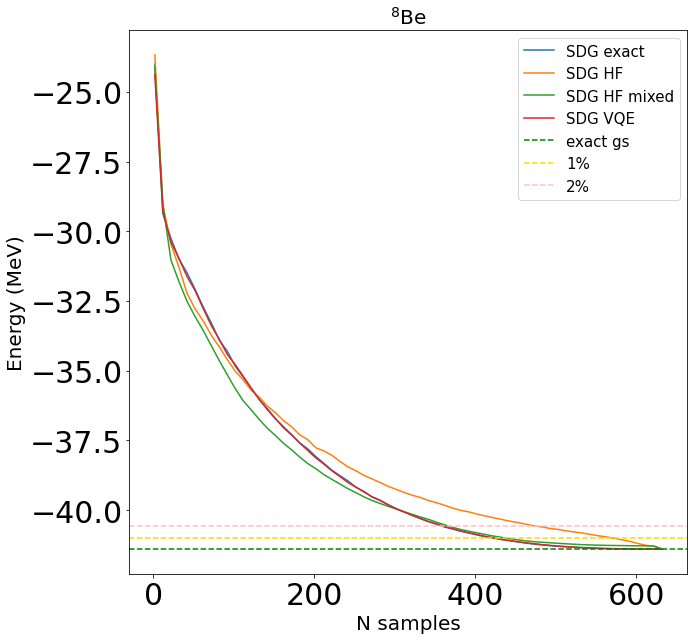

(64,)


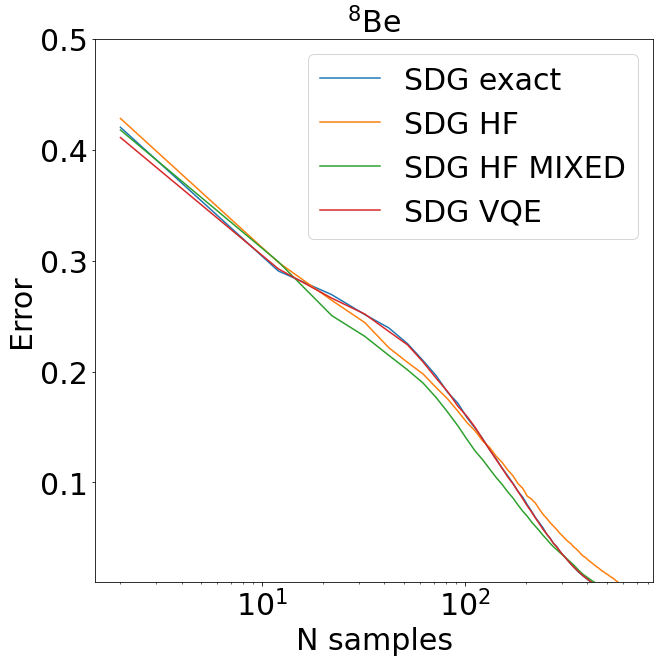

In [74]:
plt.figure(figsize=(10,10))
deviations_vqe=np.abs(np.asarray(deviations_vqe))
deviations=np.abs(np.asarray(deviations))
deviations_exact=np.abs(np.asarray(deviations_exact))
deviations_mixed=np.abs(np.asarray(deviations_mixed))
# plt.errorbar(ns_instances,energies_sdg_gs,yerr=deviations_exact[:,0],label='SDG exact')
# plt.errorbar(ns_instances,energies_sdg_hf,yerr=deviations[:,0],label='SDG HF')
# plt.errorbar(ns_instances,energies_sdg_hf_mixed,yerr=deviations_mixed[:,0],label='SDG HF mixed')
# plt.errorbar(ns_instances,energies_sdg_vqe,yerr=deviations_vqe[:,0],label='SDG VQE')

plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
plt.plot(ns_instances,energies_sdg_vqe,label='SDG VQE')

#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
energies_sdg_vqe=np.asarray(energies_sdg_vqe)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')
plt.plot(ns_instances,np.abs((energies_sdg_vqe-egs[0])/egs[0]),label='SDG VQE')
plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogx()
plt.ylim([0.01,0.5])
plt.legend(fontsize=30)
plt.show()